In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
class layer_dense:
    'Neural network dense layer'
    
    # initialization (weights and biases)
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons) 
        self.biases = np.zeros((1,n_neurons))

    # output
    def forward(self, inputs):
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
      
    def backward(self, dvalues):
        
        # gradient
        self.dinputs = dvalues.dot(self.weights.T)
        
        # Gradients on parameters
        self.dweights = self.inputs.T.dot(dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        
class activation_ReLU:
    'rectified linear unit activation function'
    
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dvalues):

        # copy dvalues
        self.dinputs = dvalues.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
class activation_softmax:
    'softmax activation function'
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dvalues):

        
        # initialized gradient (derivative) array
        self.dinputs = np.zeros(dvalues.shape)
        
        # For each data point, compute gradient
        for i in range(len(dvalues)):
            output_row = self.output[i]
            dvalues_row = dvalues[i]
            
            # Flatten output array
            output_row = output_row.reshape(-1, 1)

            # Calculate derivative matrix of the output
            derivative_matrix = np.diagflat(output_row) - output_row.dot(output_row.T)
            
            # store gradient
            self.dinputs[i] = dvalues_row.dot(derivative_matrix)


class loss:
    def calculate(self, output,y):
        sample_losses = self.forward(output,y)
        loss = np.mean(sample_losses)
        return loss
    
# cross-entropy loss        
class loss_crossentropy(loss):
    
    def forward(self, y_pred, y_true):
        
        # number of data points
        n_samples = len(y_pred)
        
        # clip data to prevent division by 0
        y_pred_clipped = np.clip(y_pred, 1e-7,1 - 1e-7)
        
        # confidence values
        confidence_values = y_pred_clipped[range(n_samples),y_true]
       
        # sample losses 
        losses = -np.log(confidence_values)
        return losses
    
    
    def backward(self, dvalues, y_true):
        
        
        # Number of samples
        n_samples = len(dvalues)
    
        #one-hot matrix
        Y = np.zeros(dvalues.shape)
        Y[np.arange(len(y_true)),y_true] = 1
        
        # Calculate gradient
        self.dinputs = -Y / dvalues
        
        # Normalize gradient
        self.dinputs = self.dinputs / n_samples
        
# SGD optimizer
class optimizer_SGD:

    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases

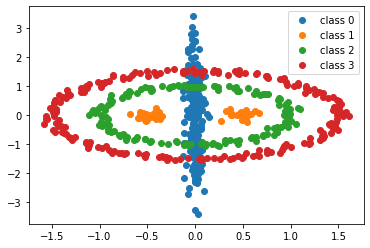

In [163]:
X = np.zeros((600,2))
y = np.zeros(600).astype('int')

# class 0
#theta = np.linspace(np.pi+0.25,2*np.pi-0.25,100) 
#X[0:100,0] = 0.4*np.cos(theta)+0.05*np.random.randn(100)
#X[0:100,1] = 0.3*np.sin(theta)+0.05*np.random.randn(100) - 0.25

X[:200] = np.random.randn(200,2).dot(np.array([[0.05,0],[0,1.25]]))

# class 1
X[200:225] = 0.1*np.random.randn(25,2) + [0.5,0]
X[225:250] = 0.1*np.random.randn(25,2) + [-0.5,0] 
y[200:250] = 1

# class 2
theta = np.linspace(0,2*np.pi,150) 
X[250:400,0] = np.sin(theta)+0.05*np.random.randn(150)
X[250:400,1] = np.cos(theta)+0.05*np.random.randn(150)
y[250:400] = 2

# class 3
theta = np.linspace(0,2*np.pi,200) 
X[400:600,0] = 1.5*np.sin(theta)+0.05*np.random.randn(200)
X[400:600,1] = 1.5*np.cos(theta)+0.05*np.random.randn(200)
y[400:600] = 3

plt.plot(X[y==0,0],X[y==0,1],'o', label='class 0')
plt.plot(X[y==1,0],X[y==1,1],'o', label='class 1')
plt.plot(X[y==2,0],X[y==2,1],'o', label='class 2')
plt.plot(X[y==3,0],X[y==3,1],'o', label='class 3')
plt.legend()

In [168]:
# neural network 
layer1 = layer_dense(n_inputs = 2, n_neurons = 20)
activation1 = activation_ReLU()
layer2 = layer_dense(n_inputs = 20, n_neurons = 4)
activation2 = activation_softmax()
loss_function = loss_crossentropy()

In [169]:
# optimizer
optimizer = optimizer_SGD(learning_rate=1)

In [170]:
n_epochs = 2000
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    
    # loss
    losses = loss_function.forward(activation2.output,y)
    loss[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy[i] = 100*np.sum(y_pred == y)/len(y)
    
    # backward pass
    loss_function.backward(activation2.output,y)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss[i],3)))
        print('accuracy: '+str(accuracy[i]))
        print('------------------------')

epoch: 0
loss: 1.386
accuracy: 32.666666666666664
------------------------
epoch: 100
loss: 0.643
accuracy: 67.5
------------------------
epoch: 200
loss: 0.474
accuracy: 89.33333333333333
------------------------
epoch: 300
loss: 0.436
accuracy: 91.66666666666667
------------------------
epoch: 400
loss: 0.43
accuracy: 90.5
------------------------
epoch: 500
loss: 0.409
accuracy: 91.83333333333333
------------------------
epoch: 600
loss: 0.37
accuracy: 92.33333333333333
------------------------
epoch: 700
loss: 0.326
accuracy: 93.5
------------------------
epoch: 800
loss: 0.246
accuracy: 94.33333333333333
------------------------
epoch: 900
loss: 0.207
accuracy: 95.33333333333333
------------------------
epoch: 1000
loss: 0.182
accuracy: 95.83333333333333
------------------------
epoch: 1100
loss: 0.165
accuracy: 95.83333333333333
------------------------
epoch: 1200
loss: 0.153
accuracy: 95.83333333333333
------------------------
epoch: 1300
loss: 0.143
accuracy: 95.66666666666667

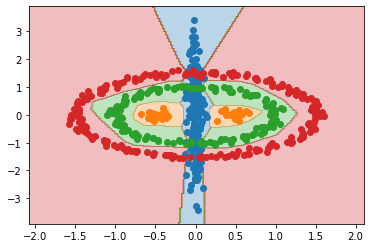

In [171]:
from matplotlib.colors import ListedColormap
# step size
h = 0.02

# mesh grid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_plot = np.c_[xx.ravel(),yy.ravel()]

# forward pass
layer1.forward(X_plot)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# predictions
y_plot = np.argmax(activation2.output, axis=1)
y_plot = y_plot.reshape(xx.shape)

# classification regions
my_cmap = ListedColormap(['C0','C1','C2','C3'])
plt.contourf(xx, yy, y_plot, cmap=my_cmap, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# dataset
plt.plot(X[y==0,0],X[y==0,1],'o', label='class 0')
plt.plot(X[y==1,0],X[y==1,1],'o', label='class 1')
plt.plot(X[y==2,0],X[y==2,1],'o', label='class 2')
plt.plot(X[y==3,0],X[y==3,1],'o', label='class 3')

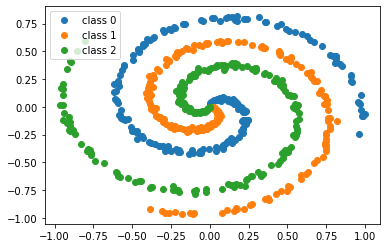

In [172]:
# spirals dataset
classes = 3
n_points = 200
noise = 0.1

X = np.zeros((n_points*classes, 2))
y = np.zeros(n_points*classes).astype('int')

for class_number in range(classes):
    ix = range(n_points*class_number, n_points*(class_number+1))
    r = np.linspace(0,1, n_points)
    t = 2*np.linspace(class_number*4, (class_number+1)*4, n_points) + np.random.randn(n_points)*noise
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = class_number
    
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o', label='class '+str(i))
plt.legend()
plt.savefig('spirals.png')

In [176]:
# neural network 
layer1 = layer_dense(n_inputs = 2, n_neurons = 5)
activation1 = activation_ReLU()
layer2 = layer_dense(n_inputs = 5, n_neurons = 3)
activation2 = activation_softmax()
loss_function = loss_crossentropy()

In [177]:
n_epochs = 2000
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    
    # loss
    losses = loss_function.forward(activation2.output,y)
    loss[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy[i] = 100*np.sum(y_pred == y)/len(y)
    
    # backward pass
    loss_function.backward(activation2.output,y)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss[i],3)))
        print('accuracy: '+str(accuracy[i]))
        print('------------------------')

epoch: 0
loss: 1.099
accuracy: 29.333333333333332
------------------------
epoch: 100
loss: 1.097
accuracy: 38.0
------------------------
epoch: 200
loss: 1.064
accuracy: 39.833333333333336
------------------------
epoch: 300
loss: 1.055
accuracy: 40.333333333333336
------------------------
epoch: 400
loss: 1.036
accuracy: 38.333333333333336
------------------------
epoch: 500
loss: 1.011
accuracy: 37.166666666666664
------------------------
epoch: 600
loss: 0.985
accuracy: 39.0
------------------------
epoch: 700
loss: 0.949
accuracy: 51.0
------------------------
epoch: 800
loss: 0.929
accuracy: 52.0
------------------------
epoch: 900
loss: 0.92
accuracy: 52.166666666666664
------------------------
epoch: 1000
loss: 0.904
accuracy: 53.0
------------------------
epoch: 1100
loss: 0.893
accuracy: 52.0
------------------------
epoch: 1200
loss: 0.889
accuracy: 52.0
------------------------
epoch: 1300
loss: 0.888
accuracy: 51.666666666666664
------------------------
epoch: 1400
loss: 0

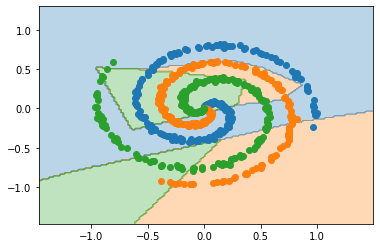

In [178]:
# step size
h = 0.02

# mesh grid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_plot = np.c_[xx.ravel(),yy.ravel()]

# forward pass
layer1.forward(X_plot)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# predictions
y_plot = np.argmax(activation2.output, axis=1)
y_plot = y_plot.reshape(xx.shape)

# classification regions
my_cmap = ListedColormap(['C0','C1','C2'])
plt.contourf(xx, yy, y_plot, cmap=my_cmap, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# dataset
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o', label='class '+str(i))
plt.savefig('spirals-regions.png')